In [1]:
import pandas as pd

# 1. read data

In [8]:
url = 'https://github.com/adebayoj/fairml/blob/master/doc/example_notebooks/propublica_data_for_fairml.csv?raw=true'
df = pd.read_csv(url)

In [11]:
# no missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6172 entries, 0 to 6171
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Two_yr_Recidivism     6172 non-null   int64
 1   Number_of_Priors      6172 non-null   int64
 2   score_factor          6172 non-null   int64
 3   Age_Above_FourtyFive  6172 non-null   int64
 4   Age_Below_TwentyFive  6172 non-null   int64
 5   African_American      6172 non-null   int64
 6   Asian                 6172 non-null   int64
 7   Hispanic              6172 non-null   int64
 8   Native_American       6172 non-null   int64
 9   Other                 6172 non-null   int64
 10  Female                6172 non-null   int64
 11  Misdemeanor           6172 non-null   int64
dtypes: int64(12)
memory usage: 578.8 KB


In [13]:
df.head()

,Two_yr_Recidivism,Number_of_Priors,score_factor,Age_Above_FourtyFive,Age_Below_TwentyFive,African_American,Asian,Hispanic,Native_American,Other,Female,Misdemeanor
0,0,0,0,1,0,0,0,0,0,1,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0
2,1,4,0,0,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,1
4,1,14,1,0,0,0,0,0,0,0,0,0


# 2. Add a column white by criterion

In [14]:
if_white = []
for id, row in df.iterrows():
    if (row['African_American'] == 0) & (row['Asian'] == 0) & (row['Hispanic'] == 0) & (row['Native_American'] == 0) & (row['Other'] == 0):
        if_white.append(1)
    else:
        if_white.append(0)
df['white'] = if_white


# 3. Add a column to the data set indicating the category of each convict

In [19]:
convict_category = []
for id, row in df.iterrows():
    if (row['Number_of_Priors'] == 0):
        convict_category.append('A')
    elif (row['Number_of_Priors'] <= 3):
        convict_category.append('B')
    elif (row['Number_of_Priors'] <= 10):
        convict_category.append('C')
    else:
        convict_category.append('D')
df['convict_ctg'] = convict_category

# 4. Regression model

Since Two_yr_Recidivism and score_factor are binary variables, the method used here is logit regression.

The regression result of Two_yr_Recidivism:
1) This regression uses maximum likelihood estimation method, but R squre is not high. This means true Two_yr_Recidivism is not good interpreted by these variables.
2) The coefficient of African_American, Age_Below_TwentyFive, convict_ctg(B, C, D) are positive, and all p-values are less than usual significant level(0.05). Positive coefficient means that increasing these variable by 1 increases the log-odds by Two_yr_Recidivism. FOr example, convict_ctg_B will increase e^(0.6897) odds to be Two_yr_Recidivismby than convict_ctg_A.
3) Though coefficient of Hispanic, Asian and Native_American are negative, the p-value are so high. That means these three variables are not significant for this model which mighe be removed.
4) The coefficent of Female and Misdemeanor are negative, and all p-values are less than usual significant elvel(0.05). This means that if some one is femalethe probability of being Two_yr_Recidivismby will decreases the e^(-0.3172) than male.



In [36]:
# Regression on Two_yr_Recidivism
import statsmodels.formula.api as smf
model_two_yr = smf.logit(
    formula='Two_yr_Recidivism ~ C(convict_ctg) + C(Age_Below_TwentyFive) + C(African_American) + C(Hispanic) + C(Asian) + C(Native_American) + C(Female) + C(Misdemeanor)',
     data=df).fit()
print(model_two_yr.summary())


Optimization terminated successfully.
         Current function value: 0.617217
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:      Two_yr_Recidivism   No. Observations:                 6172
Model:                          Logit   Df Residuals:                     6161
Method:                           MLE   Df Model:                           10
Date:                Sun, 17 Jul 2022   Pseudo R-squ.:                  0.1043
Time:                        12:52:04   Log-Likelihood:                -3809.5
converged:                       True   LL-Null:                       -4253.2
Covariance Type:            nonrobust   LLR p-value:                3.143e-184
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.1339      0.071    -15.957      0.000

The regression result of score_factor:
1) Like model of Two_yr_Recidivism, R squre is not high. This means true score_factor is not good interpreted by these variables.
2) The coefficient of African_American, Age_Below_TwentyFive, convict_ctg(B, C, D), and Female are positive, and all p-values are less than usual significant elvel(0.05). Hispanic can be significant under the level of 90%. Positive coefficient means that increasing these variable by 1 increases the log-odds by score_factor. Example has been stated in the last model.
3) Different with the last model, the p-value of Asian are so high. Female and Native_American turn to be positive relationship with score_factor.


In [40]:
# Regression on score_factor
model_score = smf.logit(
    formula='score_factor ~ C(convict_ctg) + C(Age_Below_TwentyFive) + C(African_American) + C(Hispanic) + C(Asian) + C(Native_American) + C(Female) + C(Misdemeanor)', data=df).fit()
print(model_score.summary())

Optimization terminated successfully.
         Current function value: 0.536292
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:           score_factor   No. Observations:                 6172
Model:                          Logit   Df Residuals:                     6161
Method:                           MLE   Df Model:                           10
Date:                Sun, 17 Jul 2022   Pseudo R-squ.:                  0.2196
Time:                        23:29:38   Log-Likelihood:                -3310.0
converged:                       True   LL-Null:                       -4241.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.8514      0.081    -22.767      0.000

# 5. Colinear
Regressions allow one to measure a variables’ dependence on particular attributes. However, indirect effects may not be accounted for when the attributes used in the model are co-linear. Comment on whether this is the case in your regression models and why.

Answer:

No, by visualising the correlation among all variables, it is clear that only the correlation between white and African_American is high. And the remaining are still low.

<AxesSubplot:>

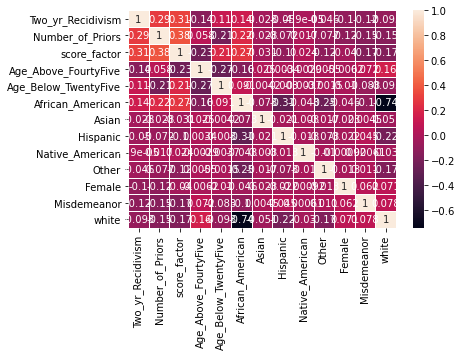

In [30]:
import seaborn as sns
%matplotlib inline
sns.heatmap(df.corr(),annot=True,lw=1)

# 6.
What experiments or analysis would you conduct in order to determine whether there is racial, gender, and/or age bias in the way that the ML model is predicting recidivism?

Answer:

Predicting recidivism belongs to superior prediction problem. Logit regression has been conducted, other methods include SVM, XGBoost and neural networks might be useful ML method